<a href="https://colab.research.google.com/github/chemprop/chemprop/blob/master/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please note that this notebook is intended to be run in Google Colab rather than as a Jupyter notebook on your local machine. Please click the "Open in Colab" button.

# Setup

In [12]:
import os
import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import scipy 
import glob

# You can safely ignore the following errors and do not need to restart the runtime; all subsequent cells should still execute without errors:

# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.

# WARNING: The following packages were previously imported in this runtime:
#   [sphinxcontrib]
# You must restart the runtime in order to use newly installed versions.

In [4]:
def plot_parity(y_true, y_pred, y_pred_unc=None):
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.xlabel('True')
    plt.ylabel('Chemprop Predicted')
    
    plt.show()
    
    return

# Train regression model

In [29]:
arguments = [
    # '--data_path', 'tests/data/regression.csv',
    '--data_path','/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data/0_properties_trimed_Murckos/01_log_d7.4_interpretable_admet.smi',
    '--target_columns','label',
    '--dataset_type', 'regression',
    '--save_dir', 'test_checkpoints_reg',
    '--epochs', '100',
    '--split_type','scaffold_balanced',
    '--save_smiles_splits'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

Command line
python /home/ymyung/miniconda3/envs/chemprop/lib/python3.10/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"de1983db-1731-4f9b-bc0f-7b5500797c06" --shell=9002 --transport="tcp" --iopub=9004 --f=/home/ymyung/.local/share/jupyter/runtime/kernel-v2-92022fO6MVsWPYf14.json
Args
{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'crossval_index_dir': None,


# Predict from file

In [30]:
arguments = [
    '--test_path', 'test_checkpoints_reg/fold_0/test_smiles.csv',
    '--preds_path', 'test_preds_reg.csv',
    '--checkpoint_dir', 'test_checkpoints_reg'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

Loading training args
Setting molecule featurization parameters to default.
Loading data


291it [00:00, 463028.25it/s]
100%|██████████| 291/291 [00:00<00:00, 332030.05it/s]


Validating SMILES
Test size = 291


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Saving predictions to test_preds_reg.csv
Elapsed time = 0:00:01


In [31]:
df = pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
df['preds'] = [x[0] for x in preds]
df

,smiles,label,preds
0,NS(=O)(=O)c1cccc2c1c([N+](=O)[O-])cc1[nH]c(=O)...,0.36,0.712848
1,CCC(CC)NC(=O)c1cnn(-c2ccccn2)c1N=S(=O)(O)c1ccc...,0.27,0.494639
2,CCCC(=O)N1CCN(c2nnc(-c3ccccc3)c3ccccc23)CC1,3.20,3.672955
3,CN(C)C(=O)C(Cc1ccccc1)NC(=O)c1cc2sccc2[nH]1,3.10,3.334751
4,CC(C)C(NC(=O)Cn1c(-c2ccc(F)cc2)ncc(NC(=O)OCc2c...,2.22,1.933683
...,...,...,...
286,NS(=O)(=O)c1cccc(Nc2nccc(Nc3c(Cl)ccc4c3OCO4)n2)c1,2.97,2.846136
287,O=C(Nc1ccccn1)c1ccc2[nH]c(-c3ccc(NC(=O)C45CC6C...,4.24,3.615396
288,O=C1COC2(CCN(S(=O)(=O)c3ccc(-c4ccc5cccnc5c4)cc...,3.24,3.166051
289,Cc1nc(C)c(-c2ccc(C34CCC(C(=O)O)(CC3)CC4)cc2)nc...,1.30,1.550934


In [32]:
pearson = scipy.stats.pearsonr(df['label'], df['preds'])
rmse = mean_squared_error(df['label'], df['preds'], squared=False)
print(pearson, rmse)

PearsonRResult(statistic=0.8778442576268555, pvalue=2.138550465080666e-94) 0.5492302719710523


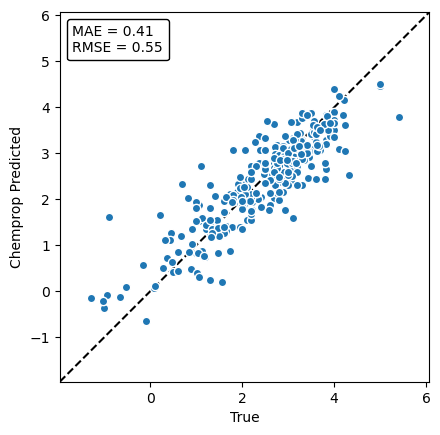

In [33]:
plot_parity(df.label, df.preds)

In [46]:
regression_list = ['01_log_d7.4_interpretable_admet','02_pka_acid_interpretable_admet',
'03_pka_basic_interpretable_admet','04_log_vp_interpretable_admet','05_bp_interpretable_admet',
'06_mp_interpretable_admet','08_log_p_interpretable_admet','09_hydration_free_energy_interpretable_admet',
'10_log_s_interpretable_admet','24_ppb_interpretable_admet','49_bioconcentration_factor_interpretable_admet',
'55_fathead_minnow_lc50_interpretable_admet','66_rat_oral_acute_toxicity_ld50_interpretable_admet',
'74_tetrahymena_pyriformis_interpretable_admet']

dir_path = '/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data'
all_smiles_list = glob.glob(os.path.join(dir_path,'**/*.smi'))
all_smiles_list = [smi for smi in all_smiles_list if 'Murckos' in smi]
all_smiles_list = [smi for smi in all_smiles_list if 'interpretable' in smi]
interpretable_regression_tasks = list()
interpretable_classification_tasks = list()

# print(all_smiles_list)
for each in all_smiles_list:
    for eeach in regression_list:
        if eeach in each:
            interpretable_regression_tasks.append(each)
        else:
            interpretable_classification_tasks.append(each)
interpretable_regression_tasks = list(set(interpretable_regression_tasks))
interpretable_classification_tasks = list(set(interpretable_classification_tasks))
print(interpretable_regression_tasks)

for each in interpretable_regression_tasks:
    data_path = each
    save_dir = '{}_reg'.format(os.path.basename(each).split('.smi')[0])
    arguments = [
    '--data_path', data_path,
    '--target_columns','label',
    '--dataset_type', 'regression',
    '--save_dir', save_dir,
    '--epochs', '100',
    '--split_type','scaffold_balanced',
    '--save_smiles_splits',
    '--quite', 'True',
    '--extra_metrics', 'r2'
    ]

    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

    arguments = [
    '--test_path', '{}/fold_0/test_smiles.csv'.format(save_dir),
    '--preds_path', '{}/test_preds_reg.csv'.format(save_dir),
    '--checkpoint_dir', save_dir
    ]

    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)


    df = pd.read_csv('{}/fold_0/test_full.csv'.format(save_dir))
    df['preds'] = [x[0] for x in preds]
    # df
    pearson = scipy.stats.pearsonr(df['label'], df['preds'])
    rmse = mean_squared_error(df['label'], df['preds'], squared=False)
    print(pearson, rmse)


['/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data/0_properties_trimed_Murckos/04_log_vp_interpretable_admet.smi', '/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data/0_properties_trimed_Murckos/06_mp_interpretable_admet.smi', '/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data/0_properties_trimed_Murckos/02_pka_acid_interpretable_admet.smi', '/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data/5-toxicity_trimed_Murckos/66_rat_oral_acute_toxicity_ld50_interpretable_admet.smi', '/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data/0_properties_trimed_Murckos/01_log_d7.4_interpretable_admet.smi', '/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data/5-toxicity_trimed_Murckos/55_fathead_minnow_lc50_interpretable_admet.smi', '/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data/5-toxicity_trimed_Murckos/49_bioconcentration_factor_interpretable_admet.smi', '/home/ymyung/projects/deeppk/1_dataset/pk_data/processed_data/0

usage: ipykernel_launcher.py --data_path DATA_PATH
                             [--target_columns [TARGET_COLUMNS ...]]
                             [--ignore_columns [IGNORE_COLUMNS ...]]
                             --dataset_type
                             {regression,classification,multiclass,spectra}
                             [--loss_function {mse,bounded_mse,binary_cross_entropy,cross_entropy,mcc,sid,wasserstein,mve,evidential,dirichlet}]
                             [--multiclass_num_classes MULTICLASS_NUM_CLASSES]
                             [--separate_val_path SEPARATE_VAL_PATH]
                             [--separate_test_path SEPARATE_TEST_PATH]
                             [--spectra_phase_mask_path SPECTRA_PHASE_MASK_PATH]
                             [--data_weights_path DATA_WEIGHTS_PATH]
                             [--target_weights [TARGET_WEIGHTS ...]]
                             [--split_type {random,scaffold_balanced,predetermined,crossval,cv,cv-no-test,in

SystemExit: 2

/home/ymyung/miniconda3/envs/chemprop/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Predict from SMILES list

In [9]:
smiles = [['CCC'], ['CCCC'], ['OCC']]
arguments = [
    '--test_path', '/dev/null',
    '--preds_path', '/dev/null',
    '--checkpoint_dir', 'test_checkpoints_reg'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args, smiles=smiles)

Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 3


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

Saving predictions to /dev/null
Elapsed time = 0:00:01


In [11]:
preds

[[-1.0928406177736267], [-1.9473260860029453], [-0.000890267275232226]]

# Load model once, predict multiple times

In [ ]:
arguments = [
    '--test_path', '/dev/null',
    '--preds_path', '/dev/null',
    '--checkpoint_dir', 'test_checkpoints_reg'
]

args = chemprop.args.PredictArgs().parse_args(arguments)

model_objects = chemprop.train.load_model(args=args)

smiles = [['CCC'], ['CCCC'], ['OCC']]
preds = chemprop.train.make_predictions(args=args, smiles=smiles, model_objects=model_objects)

smiles = [['CCCC'], ['CCCCC'], ['COCC']]
preds = chemprop.train.make_predictions(args=args, smiles=smiles, model_objects=model_objects)

# Reactions

In [ ]:
reaction_reg_df = pd.read_csv('tests/data/reaction_regression.csv')
reaction_reg_df

In [ ]:
arguments = [
    '--data_path', 'tests/data/reaction_regression.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'test_checkpoints_reaction',
    '--epochs', '5',
    '--reaction',
    '--save_smiles_splits'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

In [ ]:
arguments = [
    '--test_path', 'test_checkpoints_reaction/fold_0/test_smiles.csv',
    '--preds_path', 'test_preds_reaction.csv',
    '--checkpoint_dir', 'test_checkpoints_reaction'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

In [ ]:
df = pd.read_csv('test_checkpoints_reaction/fold_0/test_full.csv')
df['preds'] = [x[0] for x in preds]

plot_parity(df.ea, df.preds)

# Multiple-Molecule Inputs

In [ ]:
multimolecule_df = pd.read_csv('tests/data/classification_multimolecule.csv')
multimolecule_df

In [ ]:
arguments = [
    '--data_path', 'tests/data/classification_multimolecule.csv',
    '--dataset_type', 'classification',
    '--save_dir', 'test_checkpoints_multimolecule',
    '--epochs', '5',
    '--save_smiles_splits',
    '--number_of_molecules', '2',
    '--split_key_molecule', '1' # defaults to 0 (1st column) if not specified
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

In [ ]:
arguments = [
    '--test_path', 'test_checkpoints_multimolecule/fold_0/test_smiles.csv',
    '--preds_path', 'test_preds_multimolecule.csv',
    '--checkpoint_dir', 'test_checkpoints_multimolecule',
    '--number_of_molecules', '2',
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

# Split Type

In [ ]:
arguments = [
    '--data_path', 'tests/data/regression.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'test_checkpoints_splits',
    '--epochs', '5',
    '--split_type', 'scaffold_balanced',
    '--save_smiles_splits'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

In [ ]:
arguments = [
    '--test_path', 'test_checkpoints_splits/fold_0/test_smiles.csv',
    '--preds_path', 'test_preds_splits.csv',
    '--checkpoint_dir', 'test_checkpoints_splits',
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

In [ ]:
df = pd.read_csv('test_checkpoints_splits/fold_0/test_full.csv')
df['preds'] = [x[0] for x in preds]

plot_parity(df.logSolubility, df.preds)

# Ensembling and Uncertainty

In [ ]:
arguments = [
    '--data_path', 'tests/data/reaction_regression.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'test_checkpoints_ensemble',
    '--epochs', '5',
    '--reaction',
    '--save_smiles_splits',
    '--ensemble_size', '5',
    '--split_type', 'scaffold_balanced'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

In [ ]:
arguments = [
    '--test_path', 'test_checkpoints_ensemble/fold_0/test_smiles.csv',
    '--preds_path', 'test_preds_ensemble.csv',
    '--checkpoint_dir', 'test_checkpoints_ensemble',
    '--ensemble_variance'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

In [ ]:
preds_df = pd.read_csv('test_preds_ensemble.csv')
preds_df

In [ ]:
df = pd.read_csv('test_checkpoints_ensemble/fold_0/test_full.csv')
plot_parity(df.ea, preds_df.ea, preds_df.ea_ensemble_uncal_var)

# Fingerprint

In [ ]:
arguments = [
    '--test_path', 'tests/data/regression.csv',
    '--preds_path', 'test_preds_fingerprint.csv',
    '--checkpoint_dir', 'test_checkpoints_reg',
    '--fingerprint_type', 'MPN'
]

args = chemprop.args.FingerprintArgs().parse_args(arguments)
preds = chemprop.train.molecule_fingerprint.molecule_fingerprint(args=args)

In [ ]:
preds.squeeze().shape

In [ ]:
df = pd.read_csv('tests/data/regression.csv')

pca = PCA(n_components=2)
pca_xy = pca.fit_transform(preds.squeeze())
plt.scatter(pca_xy[:,0], pca_xy[:,1], s=30, c=df.logSolubility, edgecolor='w')
plt.colorbar(label='logSolubility')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# Spectra

In [ ]:
arguments = [
    '--data_path', 'tests/data/spectra.csv',
    '--dataset_type', 'spectra',
    '--save_dir', 'test_checkpoints_spectra',
    '--epochs', '5',
    '--features_path', 'tests/data/spectra_features.csv',
    '--split_type', 'random_with_repeated_smiles',
    '--save_smiles_splits'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)       

In [ ]:
arguments = [
    '--test_path', 'test_checkpoints_spectra/fold_0/test_smiles.csv',
    '--preds_path', 'test_preds_spectra.csv',
    '--checkpoint_dir', 'test_checkpoints_spectra',
    '--features_path', 'tests/data/spectra_features.csv'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

# Pretraining / Transfer Learning

In [ ]:
arguments = [
    '--data_path', 'tests/data/regression.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'test_checkpoints_transfer',
    '--epochs', '5',
    '--save_smiles_splits'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)       

In [ ]:
arguments = [
    '--data_path', 'tests/data/regression.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'test_checkpoints_transfer',
    '--epochs', '5',
    '--checkpoint_frzn', 'test_checkpoints_transfer/fold_0/model_0/model.pt'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)       

In [ ]:
arguments = [
    '--test_path', 'test_checkpoints_transfer/fold_0/test_smiles.csv',
    '--preds_path', 'test_preds_transfer.csv',
    '--checkpoint_dir', 'test_checkpoints_transfer',
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)